In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm
import copy
import tqdm

from bnn_hmc.utils import data_utils
from bnn_hmc.utils import models
from bnn_hmc.utils import losses
from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import tree_utils
from bnn_hmc.utils import precision_utils
from bnn_hmc.utils import optim_utils
from bnn_hmc.utils import script_utils
import sklearn.datasets
import cmocean

import optax
import functools

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def twospirals(n_samples, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    onp.random.seed(random_state)
    
    n = onp.sqrt(onp.random.rand(n_samples,1)) * 600 * (2*onp.pi)/360
    d1x = -1.5*onp.cos(n)*n + onp.random.randn(n_samples,1) * noise
    d1y =  1.5*onp.sin(n)*n + onp.random.randn(n_samples,1) * noise
    return (onp.vstack((onp.hstack((d1x,d1y)), onp.hstack((-d1x,-d1y)))),
            onp.hstack((onp.zeros(n_samples), onp.ones(n_samples))))

x, y = twospirals(n_samples=200, noise=0.6, random_state=920)
# x, y = twospirals(n_samples=100, noise=0.5, random_state=920)
# mask = onp.logical_and(x[:, 0] < 0.5, x[:, 0] > -0.5)

mask = (onp.linalg.norm(x, axis=-1) > 13)
y[mask] = 1 - y[mask]

# noise_level = 0.1
# idx = onp.arange(len(x))
# onp.random.shuffle(idx)
# flip_idx = idx[:int(noise_level * len(x))]
# y[flip_idx] = 1 - y[flip_idx]

mask = onp.logical_and(x[:, 0] < 0.5, x[:, 1] < 0)
x, y = x[mask], y[mask]
x = onp.concatenate([x, -x, x * onp.array([[1., -1]]), x * onp.array([[-1., 1]])])
y = onp.concatenate([y, y, y, y])

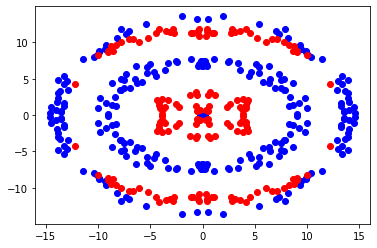

In [4]:
plt.plot(x[:, 0][y == 0], x[:, 1][y == 0], "bo")
plt.plot(x[:, 0][y == 1], x[:, 1][y == 1], "ro")

In [5]:
idx = onp.arange(len(x))
onp.random.shuffle(idx)
n_train = int(len(x) * 0.8)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [6]:
num_devices = len(jax.devices())
train_set = (x[train_idx], y[train_idx])
test_set = (x[test_idx], y[test_idx])
train_set = data_utils.pmap_dataset(train_set, num_devices)
test_set = data_utils.pmap_dataset(test_set, num_devices)

In [7]:
data_info = {"num_classes": 2}
net_fn = models.make_mlp_classification(data_info, layer_dims=[100, 100, 100])
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
net_apply = precision_utils.rewrite_high_precision(net_apply)

## Prior and likelihood

In [8]:
prior_std = 1000.
weight_decay = 1 / prior_std**2

task = data_utils.Task("classification")
(likelihood_factory, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)
log_prior_fn, log_prior_diff_fn = (
    losses.make_gaussian_log_prior(weight_decay, 1.))
log_likelihood_fn = losses.make_xent_log_likelihood(1.)

## SGD

In [9]:
total_steps = 10000
init_lr = 1.e-4
momentum_decay = 0.

lr_schedule = optim_utils.make_cosine_lr_schedule(
    init_lr, total_steps)
optimizer = optim_utils.make_sgd_optimizer(
    lr_schedule, momentum_decay=momentum_decay)

In [108]:
key = jax.random.PRNGKey(0)
param_seed = 0

params, net_state = net.init(jax.random.PRNGKey(param_seed), (train_set[0][0, :1], None), True)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))
opt_state = optimizer.init(params)
key = jax.random.split(key, num_devices)

In [72]:
sgd_train_epoch = script_utils.time_fn(train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, 1))

In [73]:
for iteration in tqdm.tqdm(range(0, total_steps)):

    (params, net_state, opt_state, logprob_avg, key), iteration_time = (
      sgd_train_epoch(params, net_state, opt_state, train_set, key))
    if iteration % 1000 == 0:
        print(logprob_avg)

  1%|          | 52/10000 [00:00<01:44, 94.91it/s] 

161973.86


 11%|█         | 1072/10000 [00:02<00:17, 516.15it/s]

161983.22


 21%|██        | 2070/10000 [00:04<00:15, 518.30it/s]

161986.1


 31%|███       | 3087/10000 [00:06<00:12, 539.26it/s]

161988.86


 41%|████      | 4106/10000 [00:08<00:11, 524.34it/s]

161991.52


 51%|█████     | 5082/10000 [00:10<00:09, 527.07it/s]

161993.67


 61%|██████    | 6052/10000 [00:12<00:08, 482.49it/s]

161995.06


 71%|███████   | 7098/10000 [00:14<00:05, 499.27it/s]

161995.86


 81%|████████  | 8059/10000 [00:16<00:03, 531.10it/s]

161996.3


 91%|█████████ | 9068/10000 [00:18<00:01, 508.58it/s]

161996.45


100%|██████████| 10000/10000 [00:20<00:00, 492.38it/s]


In [74]:
_, test_preds = predict_fn(net_apply, params, net_state, test_set)
(jnp.argmax(test_preds[0], axis=-1) == test_set[1][0]).mean()

DeviceArray(0.6818182, dtype=float32)

In [75]:
_, train_preds = predict_fn(net_apply, params, net_state, train_set)
(jnp.argmax(train_preds[0], axis=-1) == train_set[1][0]).mean()

DeviceArray(0.8255814, dtype=float32)

In [10]:
grid_d1 = onp.linspace(-15, 15, 50)
grid_d2 = onp.linspace(-15, 15, 50)

grid_d1, grid_d2 = onp.meshgrid(grid_d1, grid_d2)
grid = onp.stack([grid_d1.reshape(-1), grid_d2.reshape(-1)]).T
grid_set = (grid[None, :], None)

In [10]:
_, grid_probs = predict_fn(net_apply, params, net_state, grid_set)
grid_preds = jnp.argmax(grid_probs[0], axis=-1)
grid_confs = jnp.max(grid_probs[0], axis=-1)

NameError: name 'params' is not defined

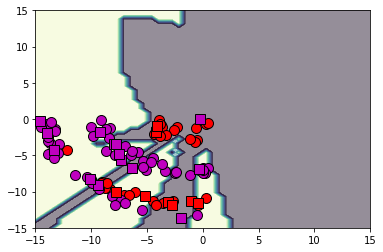

In [78]:
# plt.imshow(grid_preds.reshape((20, 20)))
levels = onp.linspace(0., 1., 21)

plt.contourf(
    grid_d1, grid_d2, grid_preds.reshape((50, 50)),
    vmin=0., vmax=1., levels=levels, cmap=cmocean.cm.deep,
    alpha=0.5#cmap=cmocean.cm.thermal
)
class_1 = (train_set[1][0] == 1)
class_0 = jnp.logical_not(class_1)
plt.plot(train_set[0][0, :, 0][class_1], train_set[0][0, :, 1][class_1], "ro", ms=10, mec="k")
plt.plot(train_set[0][0, :, 0][class_0], train_set[0][0, :, 1][class_0], "mo", ms=10, mec="k")

class_1 = (test_set[1][0] == 1)
class_0 = jnp.logical_not(class_1)
plt.plot(test_set[0][0, :, 0][class_1], test_set[0][0, :, 1][class_1], "rs", ms=10, mec="k")
plt.plot(test_set[0][0, :, 0][class_0], test_set[0][0, :, 1][class_0], "ms", ms=10, mec="k")

## HMC

In [21]:
temperature = .4
prior_std = .3
weight_decay = 1 / prior_std**2


task = data_utils.Task("classification")
(likelihood_factory, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)
log_prior_fn, log_prior_diff_fn = (
    losses.make_gaussian_log_prior(weight_decay, 1.))
log_likelihood_fn = losses.make_xent_log_likelihood(temperature)

In [22]:
weight_decay

11.11111111111111

In [23]:
step_size = 3e-6
trajectory_len = jnp.pi / 2 / jnp.sqrt(weight_decay)
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)

Leapfrog steps per iteration: 157080


In [24]:
key = jax.random.PRNGKey(0)
param_seed = 0

params, net_state = net.init(jax.random.PRNGKey(param_seed), (train_set[0][0, :1], None), True)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [25]:
update, get_log_prob_and_grad = train_utils.make_hmc_update(
    net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    max_num_leapfrog_steps, 1., 0.)

In [26]:
# Initial log-prob and grad values
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(train_set, params, net_state))

In [27]:
num_iterations = 100
all_test_preds = []
all_grid_preds = []
key = jax.random.PRNGKey(0)

for iteration in tqdm.tqdm(range(num_iterations)):

    (params, net_state, log_likelihood, state_grad, step_size, key,
     accept_prob, accepted) = (
        update(train_set, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, True))
    # Evaluation
    _, test_predictions = onp.asarray(
      predict_fn(net_apply, params, net_state, test_set))
    _, grid_probs = predict_fn(net_apply, params, net_state, grid_set)
    if accepted:
        all_grid_preds.append(grid_probs)
        all_test_preds.append(test_predictions)

    print("It: {} \t Accept P: {} \t Accepted {} \t Log-likelihood: {}".format(
            iteration, accept_prob, accepted, log_likelihood))

all_test_preds = jnp.concatenate(all_test_preds, 0)
all_grid_preds = jnp.concatenate(all_grid_preds, 0)

  0%|          | 0/100 [00:00<?, ?it/s]/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
  1%|          | 1/100 [00:37<1:01:40, 37.38s/it]

It: 0 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -375.12139892578125


  2%|▏         | 2/100 [01:14<1:00:52, 37.27s/it]

It: 1 	 Accept P: 0.999786376953125 	 Accepted True 	 Log-likelihood: -268.5409851074219


  3%|▎         | 3/100 [01:51<1:00:11, 37.23s/it]

It: 2 	 Accept P: 0.9723736643791199 	 Accepted True 	 Log-likelihood: -273.6896057128906


  4%|▍         | 4/100 [02:29<59:35, 37.25s/it]  

It: 3 	 Accept P: 0.990659773349762 	 Accepted True 	 Log-likelihood: -251.60423278808594


  5%|▌         | 5/100 [03:06<59:09, 37.36s/it]

It: 4 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -182.77377319335938


  6%|▌         | 6/100 [03:44<58:42, 37.47s/it]

It: 5 	 Accept P: 0.9496602416038513 	 Accepted True 	 Log-likelihood: -78.3099365234375


  7%|▋         | 7/100 [04:21<58:09, 37.52s/it]

It: 6 	 Accept P: 0.9995194673538208 	 Accepted True 	 Log-likelihood: -99.34532165527344


  8%|▊         | 8/100 [04:59<57:36, 37.58s/it]

It: 7 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -90.63621520996094


  9%|▉         | 9/100 [05:37<57:01, 37.60s/it]

It: 8 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -92.30635070800781


 10%|█         | 10/100 [06:14<56:25, 37.62s/it]

It: 9 	 Accept P: 0.9998812079429626 	 Accepted True 	 Log-likelihood: -77.40057373046875


 11%|█         | 11/100 [06:52<55:50, 37.65s/it]

It: 10 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -85.75374603271484


 12%|█▏        | 12/100 [07:30<55:14, 37.66s/it]

It: 11 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -78.45793151855469


 13%|█▎        | 13/100 [08:08<54:37, 37.68s/it]

It: 12 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -85.23095703125


 14%|█▍        | 14/100 [08:45<53:59, 37.67s/it]

It: 13 	 Accept P: 0.9395062327384949 	 Accepted True 	 Log-likelihood: -82.79560852050781


 15%|█▌        | 15/100 [09:23<53:21, 37.66s/it]

It: 14 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -91.81605529785156


 16%|█▌        | 16/100 [10:00<52:42, 37.65s/it]

It: 15 	 Accept P: 0.9865829944610596 	 Accepted True 	 Log-likelihood: -67.81454467773438


 17%|█▋        | 17/100 [10:38<52:04, 37.64s/it]

It: 16 	 Accept P: 0.9922103881835938 	 Accepted True 	 Log-likelihood: -97.49090576171875


 18%|█▊        | 18/100 [11:16<51:28, 37.66s/it]

It: 17 	 Accept P: 0.984872043132782 	 Accepted True 	 Log-likelihood: -71.52014923095703


 19%|█▉        | 19/100 [11:54<50:53, 37.70s/it]

It: 18 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -112.32965087890625


 20%|██        | 20/100 [12:31<50:13, 37.67s/it]

It: 19 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -83.76341247558594


 21%|██        | 21/100 [13:09<49:36, 37.67s/it]

It: 20 	 Accept P: 0.9611331224441528 	 Accepted True 	 Log-likelihood: -88.01704406738281


 22%|██▏       | 22/100 [13:46<48:56, 37.65s/it]

It: 21 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -72.35910034179688


 23%|██▎       | 23/100 [14:24<48:19, 37.66s/it]

It: 22 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -85.302490234375


 24%|██▍       | 24/100 [15:02<47:42, 37.67s/it]

It: 23 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -82.65736389160156


 25%|██▌       | 25/100 [15:39<47:05, 37.68s/it]

It: 24 	 Accept P: 0.9613531827926636 	 Accepted True 	 Log-likelihood: -105.56181335449219


 26%|██▌       | 26/100 [16:17<46:29, 37.69s/it]

It: 25 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -82.4526138305664


 27%|██▋       | 27/100 [16:55<45:52, 37.71s/it]

It: 26 	 Accept P: 0.9888927340507507 	 Accepted True 	 Log-likelihood: -93.53069305419922


 28%|██▊       | 28/100 [17:33<45:14, 37.71s/it]

It: 27 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -76.93266296386719


 29%|██▉       | 29/100 [18:10<44:37, 37.71s/it]

It: 28 	 Accept P: 0.9996339082717896 	 Accepted True 	 Log-likelihood: -87.65196228027344


 30%|███       | 30/100 [18:48<43:58, 37.69s/it]

It: 29 	 Accept P: 0.9684054255485535 	 Accepted True 	 Log-likelihood: -86.856201171875


 31%|███       | 31/100 [19:26<43:23, 37.73s/it]

It: 30 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -87.95834350585938


 32%|███▏      | 32/100 [20:04<42:44, 37.72s/it]

It: 31 	 Accept P: 0.9446669220924377 	 Accepted True 	 Log-likelihood: -89.80543518066406


 33%|███▎      | 33/100 [20:41<42:05, 37.69s/it]

It: 32 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -80.07658386230469


 34%|███▍      | 34/100 [21:19<41:29, 37.72s/it]

It: 33 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -81.31730651855469


 35%|███▌      | 35/100 [21:57<40:51, 37.72s/it]

It: 34 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -96.44093322753906


 36%|███▌      | 36/100 [22:34<40:12, 37.70s/it]

It: 35 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -104.65365600585938


 37%|███▋      | 37/100 [23:12<39:32, 37.66s/it]

It: 36 	 Accept P: 0.9376659393310547 	 Accepted True 	 Log-likelihood: -76.94036865234375


 38%|███▊      | 38/100 [23:50<38:55, 37.67s/it]

It: 37 	 Accept P: 0.9939150810241699 	 Accepted True 	 Log-likelihood: -85.89128112792969


 39%|███▉      | 39/100 [24:27<38:17, 37.67s/it]

It: 38 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -84.01210021972656


 40%|████      | 40/100 [25:05<37:40, 37.67s/it]

It: 39 	 Accept P: 0.9514878392219543 	 Accepted True 	 Log-likelihood: -90.98957824707031


 41%|████      | 41/100 [25:43<37:01, 37.66s/it]

It: 40 	 Accept P: 0.9756656289100647 	 Accepted True 	 Log-likelihood: -102.4819107055664


 42%|████▏     | 42/100 [26:20<36:24, 37.67s/it]

It: 41 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -84.4572525024414


 43%|████▎     | 43/100 [26:58<35:46, 37.66s/it]

It: 42 	 Accept P: 0.9893907904624939 	 Accepted True 	 Log-likelihood: -89.4866943359375


 44%|████▍     | 44/100 [27:36<35:08, 37.65s/it]

It: 43 	 Accept P: 0.9926344156265259 	 Accepted True 	 Log-likelihood: -90.27384948730469


 45%|████▌     | 45/100 [28:13<34:34, 37.71s/it]

It: 44 	 Accept P: 0.9967151880264282 	 Accepted True 	 Log-likelihood: -97.04885864257812


 46%|████▌     | 46/100 [28:51<33:55, 37.70s/it]

It: 45 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -81.16203308105469


 47%|████▋     | 47/100 [29:29<33:17, 37.69s/it]

It: 46 	 Accept P: 0.9850373864173889 	 Accepted True 	 Log-likelihood: -90.8458023071289


 48%|████▊     | 48/100 [30:06<32:39, 37.68s/it]

It: 47 	 Accept P: 0.9878143668174744 	 Accepted True 	 Log-likelihood: -90.82688903808594


 49%|████▉     | 49/100 [30:44<32:01, 37.67s/it]

It: 48 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -86.19317626953125


 50%|█████     | 50/100 [31:22<31:23, 37.66s/it]

It: 49 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -101.07374572753906


 51%|█████     | 51/100 [32:00<30:48, 37.73s/it]

It: 50 	 Accept P: 0.9963749647140503 	 Accepted True 	 Log-likelihood: -84.17041015625


 52%|█████▏    | 52/100 [32:37<30:09, 37.71s/it]

It: 51 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -82.32398986816406


 53%|█████▎    | 53/100 [33:15<29:31, 37.69s/it]

It: 52 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -83.62814331054688


 54%|█████▍    | 54/100 [33:53<28:53, 37.69s/it]

It: 53 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -77.1656723022461


 55%|█████▌    | 55/100 [34:30<28:15, 37.69s/it]

It: 54 	 Accept P: 0.9694883227348328 	 Accepted True 	 Log-likelihood: -101.37884521484375


 56%|█████▌    | 56/100 [35:08<27:38, 37.68s/it]

It: 55 	 Accept P: 0.9907806515693665 	 Accepted True 	 Log-likelihood: -78.26625061035156


 57%|█████▋    | 57/100 [35:46<27:00, 37.69s/it]

It: 56 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -77.80561828613281


 58%|█████▊    | 58/100 [36:23<26:23, 37.69s/it]

It: 57 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -96.40715026855469


 59%|█████▉    | 59/100 [37:01<25:45, 37.70s/it]

It: 58 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -106.10137939453125


 60%|██████    | 60/100 [37:39<25:07, 37.68s/it]

It: 59 	 Accept P: 0.9711281061172485 	 Accepted True 	 Log-likelihood: -80.9138412475586


 61%|██████    | 61/100 [38:16<24:29, 37.68s/it]

It: 60 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -85.95521545410156


 62%|██████▏   | 62/100 [38:54<23:51, 37.68s/it]

It: 61 	 Accept P: 0.9764922261238098 	 Accepted True 	 Log-likelihood: -73.89289855957031


 63%|██████▎   | 63/100 [39:32<23:13, 37.66s/it]

It: 62 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -99.22260284423828


 64%|██████▍   | 64/100 [40:09<22:36, 37.67s/it]

It: 63 	 Accept P: 0.9720871448516846 	 Accepted True 	 Log-likelihood: -89.62726593017578


 65%|██████▌   | 65/100 [40:47<21:58, 37.67s/it]

It: 64 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -90.71885681152344


 66%|██████▌   | 66/100 [41:25<21:20, 37.66s/it]

It: 65 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -90.70001220703125


 67%|██████▋   | 67/100 [42:02<20:42, 37.66s/it]

It: 66 	 Accept P: 0.9929448962211609 	 Accepted True 	 Log-likelihood: -92.3465576171875


 68%|██████▊   | 68/100 [42:40<20:05, 37.67s/it]

It: 67 	 Accept P: 0.9822531342506409 	 Accepted True 	 Log-likelihood: -94.67848205566406


 69%|██████▉   | 69/100 [43:18<19:30, 37.76s/it]

It: 68 	 Accept P: 0.9441697597503662 	 Accepted True 	 Log-likelihood: -77.14227294921875


 70%|███████   | 70/100 [43:57<19:08, 38.29s/it]

It: 69 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -100.44086456298828


 71%|███████   | 71/100 [44:36<18:30, 38.30s/it]

It: 70 	 Accept P: 0.9350940585136414 	 Accepted True 	 Log-likelihood: -77.4247055053711


 72%|███████▏  | 72/100 [45:14<17:47, 38.12s/it]

It: 71 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -100.22789001464844


 73%|███████▎  | 73/100 [45:51<17:05, 37.98s/it]

It: 72 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -75.62068939208984


 74%|███████▍  | 74/100 [46:29<16:25, 37.90s/it]

It: 73 	 Accept P: 0.9947647452354431 	 Accepted True 	 Log-likelihood: -71.62710571289062


 75%|███████▌  | 75/100 [47:06<15:45, 37.81s/it]

It: 74 	 Accept P: 0.9717210531234741 	 Accepted True 	 Log-likelihood: -83.5263442993164


 76%|███████▌  | 76/100 [47:44<15:06, 37.77s/it]

It: 75 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -90.57682800292969


 77%|███████▋  | 77/100 [48:22<14:28, 37.75s/it]

It: 76 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -81.18157958984375


 78%|███████▊  | 78/100 [49:00<13:49, 37.72s/it]

It: 77 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -101.38899230957031


 79%|███████▉  | 79/100 [49:37<13:11, 37.68s/it]

It: 78 	 Accept P: 0.9980031251907349 	 Accepted True 	 Log-likelihood: -87.77530670166016


 80%|████████  | 80/100 [50:15<12:33, 37.68s/it]

It: 79 	 Accept P: 0.9873698949813843 	 Accepted True 	 Log-likelihood: -94.44609832763672


 81%|████████  | 81/100 [50:53<11:56, 37.73s/it]

It: 80 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -80.20974731445312


 82%|████████▏ | 82/100 [51:30<11:18, 37.71s/it]

It: 81 	 Accept P: 0.9917108416557312 	 Accepted True 	 Log-likelihood: -93.56497955322266


 83%|████████▎ | 83/100 [52:08<10:40, 37.71s/it]

It: 82 	 Accept P: 0.9827104210853577 	 Accepted True 	 Log-likelihood: -72.59151458740234


 84%|████████▍ | 84/100 [52:46<10:03, 37.70s/it]

It: 83 	 Accept P: 0.9795665144920349 	 Accepted True 	 Log-likelihood: -100.49897003173828


 85%|████████▌ | 85/100 [53:23<09:25, 37.68s/it]

It: 84 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -80.96538543701172


 86%|████████▌ | 86/100 [54:01<08:47, 37.69s/it]

It: 85 	 Accept P: 0.9933086037635803 	 Accepted True 	 Log-likelihood: -98.27338409423828


 87%|████████▋ | 87/100 [54:39<08:10, 37.70s/it]

It: 86 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -93.31893157958984


 88%|████████▊ | 88/100 [55:16<07:32, 37.69s/it]

It: 87 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -87.07263946533203


 89%|████████▉ | 89/100 [55:54<06:54, 37.70s/it]

It: 88 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -86.01139068603516


 90%|█████████ | 90/100 [56:32<06:17, 37.71s/it]

It: 89 	 Accept P: 0.9985209703445435 	 Accepted True 	 Log-likelihood: -82.32501220703125


 91%|█████████ | 91/100 [57:10<05:39, 37.71s/it]

It: 90 	 Accept P: 0.9984448552131653 	 Accepted True 	 Log-likelihood: -105.30693054199219


 92%|█████████▏| 92/100 [57:47<05:01, 37.70s/it]

It: 91 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -71.6793441772461


 93%|█████████▎| 93/100 [58:25<04:24, 37.75s/it]

It: 92 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -97.75470733642578


 94%|█████████▍| 94/100 [59:03<03:46, 37.72s/it]

It: 93 	 Accept P: 0.97014319896698 	 Accepted True 	 Log-likelihood: -72.95807647705078


 95%|█████████▌| 95/100 [59:40<03:08, 37.70s/it]

It: 94 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -105.41878509521484


 96%|█████████▌| 96/100 [1:00:18<02:30, 37.71s/it]

It: 95 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -90.61656951904297


 97%|█████████▋| 97/100 [1:00:56<01:53, 37.70s/it]

It: 96 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -72.92728424072266


 98%|█████████▊| 98/100 [1:01:33<01:15, 37.68s/it]

It: 97 	 Accept P: 0.9696030616760254 	 Accepted True 	 Log-likelihood: -89.69951629638672


 99%|█████████▉| 99/100 [1:02:11<00:37, 37.68s/it]

It: 98 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -86.28756713867188


100%|██████████| 100/100 [1:02:49<00:00, 37.69s/it]

It: 99 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -93.8045883178711


In [28]:
(jnp.argmax(all_test_preds[-1], axis=-1) == test_set[1][0]).mean()
(jnp.argmax(all_test_preds[5:].mean(0), axis=-1) == test_set[1][0]).mean()
# all_test_preds[-1]

DeviceArray(0.9885057, dtype=float32)

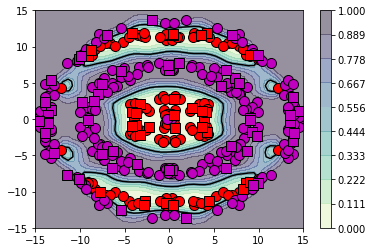

In [29]:
# plt.imshow(grid_preds.reshape((20, 20)))
levels = onp.linspace(0., 1., 10)

plt.contourf(
    grid_d1, grid_d2, all_grid_preds[1:].mean(0)[:, 0].reshape((50, 50)),
    vmin=0., vmax=1., levels=levels, cmap=cmocean.cm.deep,
    alpha=0.5#cmap=cmocean.cm.thermal
)
plt.colorbar()

plt.contour(
    grid_d1, grid_d2, all_grid_preds[1:].mean(0)[:, 0].reshape((50, 50)),
    levels=[0.5], colors=["k"]
)

class_1 = (train_set[1][0] == 1)
class_0 = jnp.logical_not(class_1)
plt.plot(train_set[0][0, :, 0][class_1], train_set[0][0, :, 1][class_1], "ro", ms=10, mec="k")
plt.plot(train_set[0][0, :, 0][class_0], train_set[0][0, :, 1][class_0], "mo", ms=10, mec="k")

class_1 = (test_set[1][0] == 1)
class_0 = jnp.logical_not(class_1)
plt.plot(test_set[0][0, :, 0][class_1], test_set[0][0, :, 1][class_1], "rs", ms=10, mec="k")
plt.plot(test_set[0][0, :, 0][class_0], test_set[0][0, :, 1][class_0], "ms", ms=10, mec="k")

# plt.xlim(-15., 0.)
# plt.ylim(-15., 0.)

In [30]:
onp.savez("augmentation_ce_fit_03_cold",
          x_train=train_set[0][0],
          y_train=train_set[1][0],
          x_test=test_set[0][0],
          y_test=test_set[1][0],
          grid_d1=grid_d1,
          grid_d2=grid_d2,
          all_grid_preds=all_grid_preds,
          all_test_preds=all_test_preds
         )

In [192]:
# onp.savez("augmentation_ce_fit",
# onp.savez("augmentation_ce_fit_035",

# onp.savez("augmentation_ce_fit_03",
#           x_train=train_set[0][0],
#           y_train=train_set[1][0],
#           x_test=test_set[0][0],
#           y_test=test_set[1][0],
#           grid_d1=grid_d1,
#           grid_d2=grid_d2,
#           all_grid_preds=all_grid_preds,
#           all_test_preds=all_test_preds
#          )

In [58]:
# onp.savez("ce_fit",
#           x_train=train_set[0][0],
#           y_train=train_set[1][0],
#           x_test=test_set[0][0],
#           y_test=test_set[1][0],
#           grid_d1=grid_d1,
#           grid_d2=grid_d2,
#           all_grid_preds=all_grid_preds,
#           all_test_preds=all_test_preds
#          )

In [210]:
# onp.savez("ce_fit_noaug",
# onp.savez("ce_fit_noaug_03",
#           x_train=train_set[0][0],
#           y_train=train_set[1][0],
#           x_test=test_set[0][0],
#           y_test=test_set[1][0],
#           grid_d1=grid_d1,
#           grid_d2=grid_d2,
#           all_grid_preds=all_grid_preds,
#           all_test_preds=all_test_preds
#          )

## Noisy Dirichlet

In [30]:
prior_std = .3
weight_decay = 1 / prior_std**2
# noise = .01
noise = .00001
temperature = 4.

task = data_utils.Task("classification")
(likelihood_factory, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)
log_prior_fn, log_prior_diff_fn = (
    losses.make_gaussian_log_prior(weight_decay, 1.))
log_likelihood_fn = losses.make_noisy_dirichlet_log_likelihood(temperature, noise)

In [31]:
step_size = 3e-6
trajectory_len = jnp.pi / 2 / jnp.sqrt(weight_decay)
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)

Leapfrog steps per iteration: 157080


In [32]:
key = jax.random.PRNGKey(0)
param_seed = 0

params, net_state = net.init(jax.random.PRNGKey(param_seed), (train_set[0][0, :1], None), True)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [33]:
update, get_log_prob_and_grad = train_utils.make_hmc_update(
    net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    max_num_leapfrog_steps, 1., 0.)

In [34]:
# Initial log-prob and grad values
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(train_set, params, net_state))

In [35]:
num_iterations = 30
all_test_preds = []
all_grid_preds = []
key = jax.random.PRNGKey(0)

for iteration in tqdm.tqdm(range(num_iterations)):

    (params, net_state, log_likelihood, state_grad, step_size, key,
     accept_prob, accepted) = (
        update(train_set, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, True))
    # Evaluation
    _, test_predictions = onp.asarray(
      predict_fn(net_apply, params, net_state, test_set))
    _, grid_probs = predict_fn(net_apply, params, net_state, grid_set)
    if accepted:
        all_grid_preds.append(grid_probs)
        all_test_preds.append(test_predictions)

    print("It: {} \t Accept P: {} \t Accepted {} \t Log-likelihood: {}".format(
            iteration, accept_prob, accepted, log_likelihood))

all_test_preds = jnp.concatenate(all_test_preds, 0)
all_grid_preds = jnp.concatenate(all_grid_preds, 0)

  0%|          | 0/30 [00:00<?, ?it/s]/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
  3%|▎         | 1/30 [00:37<18:06, 37.48s/it]

It: 0 	 Accept P: 0.9835354685783386 	 Accepted True 	 Log-likelihood: -2369.83056640625


  7%|▋         | 2/30 [01:14<17:22, 37.24s/it]

It: 1 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -2276.47998046875


 10%|█         | 3/30 [01:51<16:43, 37.18s/it]

It: 2 	 Accept P: 0.9784908890724182 	 Accepted True 	 Log-likelihood: -2022.7542724609375


 13%|█▎        | 4/30 [02:28<16:06, 37.18s/it]

It: 3 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -2020.570556640625


 17%|█▋        | 5/30 [03:06<15:32, 37.28s/it]

It: 4 	 Accept P: 0.32232606410980225 	 Accepted True 	 Log-likelihood: -1990.993896484375


 20%|██        | 6/30 [03:43<14:55, 37.31s/it]

It: 5 	 Accept P: 0.5940464735031128 	 Accepted True 	 Log-likelihood: -1978.125


 23%|██▎       | 7/30 [04:21<14:18, 37.33s/it]

It: 6 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1990.39599609375


 27%|██▋       | 8/30 [04:58<13:41, 37.34s/it]

It: 7 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1996.559326171875


 30%|███       | 9/30 [05:35<13:03, 37.33s/it]

It: 8 	 Accept P: 0.6882547736167908 	 Accepted True 	 Log-likelihood: -1999.64990234375


 33%|███▎      | 10/30 [06:13<12:26, 37.35s/it]

It: 9 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1992.3099365234375


 37%|███▋      | 11/30 [06:50<11:49, 37.35s/it]

It: 10 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1968.8330078125


 40%|████      | 12/30 [07:27<11:12, 37.34s/it]

It: 11 	 Accept P: 0.9909772276878357 	 Accepted True 	 Log-likelihood: -1909.7431640625


 43%|████▎     | 13/30 [08:05<10:34, 37.33s/it]

It: 12 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1848.432861328125


 47%|████▋     | 14/30 [08:42<09:58, 37.39s/it]

It: 13 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1874.4251708984375


 50%|█████     | 15/30 [09:20<09:23, 37.58s/it]

It: 14 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1827.282958984375


 53%|█████▎    | 16/30 [09:57<08:45, 37.51s/it]

It: 15 	 Accept P: 0.4319938123226166 	 Accepted False 	 Log-likelihood: -1827.282958984375


 57%|█████▋    | 17/30 [10:35<08:07, 37.48s/it]

It: 16 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1869.7073974609375


 60%|██████    | 18/30 [11:12<07:29, 37.43s/it]

It: 17 	 Accept P: 0.07263843715190887 	 Accepted False 	 Log-likelihood: -1869.7073974609375


 63%|██████▎   | 19/30 [11:49<06:51, 37.39s/it]

It: 18 	 Accept P: 0.5657068490982056 	 Accepted False 	 Log-likelihood: -1869.7073974609375


 67%|██████▋   | 20/30 [12:27<06:13, 37.37s/it]

It: 19 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1832.3338623046875


 70%|███████   | 21/30 [13:04<05:36, 37.39s/it]

It: 20 	 Accept P: 0.9357221126556396 	 Accepted True 	 Log-likelihood: -1824.92138671875


 73%|███████▎  | 22/30 [13:42<04:59, 37.38s/it]

It: 21 	 Accept P: 0.780847430229187 	 Accepted True 	 Log-likelihood: -1819.8714599609375


 77%|███████▋  | 23/30 [14:19<04:22, 37.46s/it]

It: 22 	 Accept P: 0.4702746570110321 	 Accepted False 	 Log-likelihood: -1819.8714599609375


 80%|████████  | 24/30 [14:57<03:45, 37.55s/it]

It: 23 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1833.465576171875


 83%|████████▎ | 25/30 [15:34<03:07, 37.50s/it]

It: 24 	 Accept P: 0.09919033944606781 	 Accepted False 	 Log-likelihood: -1833.465576171875


 87%|████████▋ | 26/30 [16:12<02:29, 37.43s/it]

It: 25 	 Accept P: 0.21509140729904175 	 Accepted False 	 Log-likelihood: -1833.465576171875


 90%|█████████ | 27/30 [16:49<01:52, 37.39s/it]

It: 26 	 Accept P: 0.03699507936835289 	 Accepted True 	 Log-likelihood: -1832.59423828125


 93%|█████████▎| 28/30 [17:26<01:14, 37.37s/it]

It: 27 	 Accept P: 0.4639976918697357 	 Accepted False 	 Log-likelihood: -1832.59423828125


 97%|█████████▋| 29/30 [18:04<00:37, 37.34s/it]

It: 28 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: -1829.561767578125


100%|██████████| 30/30 [18:41<00:00, 37.38s/it]

It: 29 	 Accept P: 0.45992693305015564 	 Accepted True 	 Log-likelihood: -1813.9423828125


In [36]:
(jnp.argmax(all_test_preds[-1], axis=-1) == test_set[1][0]).mean()
(jnp.argmax(all_test_preds[5:].mean(0), axis=-1) == test_set[1][0]).mean()
# all_test_preds[-1]

DeviceArray(0.9655172, dtype=float32)

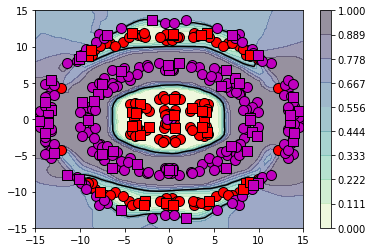

In [37]:
# plt.imshow(grid_preds.reshape((20, 20)))
levels = onp.linspace(0., 1., 10)

plt.contourf(
    grid_d1, grid_d2, all_grid_preds[5:].mean(0)[:, 0].reshape((50, 50)),
    vmin=0., vmax=1., levels=levels, cmap=cmocean.cm.deep,
    alpha=0.5#cmap=cmocean.cm.thermal
)
plt.colorbar()

plt.contour(
    grid_d1, grid_d2, all_grid_preds[5:].mean(0)[:, 0].reshape((50, 50)),
    levels=[0.5], colors=["k"]
)

class_1 = (train_set[1][0] == 1)
class_0 = jnp.logical_not(class_1)
plt.plot(train_set[0][0, :, 0][class_1], train_set[0][0, :, 1][class_1], "ro", ms=10, mec="k")
plt.plot(train_set[0][0, :, 0][class_0], train_set[0][0, :, 1][class_0], "mo", ms=10, mec="k")

class_1 = (test_set[1][0] == 1)
class_0 = jnp.logical_not(class_1)
plt.plot(test_set[0][0, :, 0][class_1], test_set[0][0, :, 1][class_1], "rs", ms=10, mec="k")
plt.plot(test_set[0][0, :, 0][class_0], test_set[0][0, :, 1][class_0], "ms", ms=10, mec="k")


In [737]:
# onp.savez("dirichlet_fit",
#           x_train=train_set[0][0],
#           y_train=train_set[1][0],
#           x_test=test_set[0][0],
#           y_test=test_set[1][0],
#           grid_d1=grid_d1,
#           grid_d2=grid_d2,
#           all_grid_preds=all_grid_preds,
#           all_test_preds=all_test_preds
#          )

In [38]:
# onp.savez("augmentation_dirichlet_fit",
#           x_train=train_set[0][0],
#           y_train=train_set[1][0],
#           x_test=test_set[0][0],
#           y_test=test_set[1][0],
#           grid_d1=grid_d1,
#           grid_d2=grid_d2,
#           all_grid_preds=all_grid_preds,
#           all_test_preds=all_test_preds
#          )